In [24]:
import pyhepmc as hep
import numpy as np
import hist
import matplotlib.pyplot as plt
import fastjet as fj
import psutil
import os
import gc
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix

# Função para verificar o uso de memória
def print_memory_usage():
    process = psutil.Process(os.getpid())
    print(f"Uso de memória: {process.memory_info().rss / 1024 ** 2:.2f} MB")

# Limite máximo de eventos
max_events = 10000  # Total de eventos a serem processados
chunk_size = 500   # Eventos por chunk

# Definir arquivos de entrada
sinal_file = '/home/levi/Documentos/Sinal_background/pp_hh_100TeV.hepmc'
background_file1 = '/home/levi/Documentos/Sinal_background/pp_zz_background_nobornQCD.hepmc'
background_file2 = '/home/levi/Documentos/Sinal_background/background_pp_jjmumu.hepmc'

# Luminosidade do FCC-hh [fb^-1] (20000 fb^-1 = 20 ab^-1)
TARGET_LUMINOSITY = 20000.0  

# Funções para extrair pesos e seções de choque (ADICIONE ESTA PARTE)
def extract_cross_section(hepmc_file):
    """Extrai a seção de choque (em pb) da linha 'C' do arquivo .hepmc."""
    with open(hepmc_file, 'r') as f:
        for line in f:
            if line.startswith('C'):
                return float(line.split()[1])  # Pega o primeiro valor da linha 'C'
    return 0.0

def extract_weights_from_hepmc(hepmc_file, max_events=max_events):
    """Extrai os pesos brutos de cada evento."""
    weights = []
    with hep.open(hepmc_file) as f:
        for i, event in enumerate(f):
            if i >= max_events:
                break
            weights.append(event.weights[-1])  # Assume que o peso nominal é o último
    return np.array(weights)

def normalize_weights(weights, cross_section, luminosity=TARGET_LUMINOSITY):
    """Normaliza os pesos para a luminosidade alvo."""
    sum_weights = np.sum(weights)
    if sum_weights <= 0:
        return np.zeros_like(weights)
    return weights * (cross_section * 1e3 * luminosity / sum_weights)  # Conversão pb -> fb

# Extrair seções de choque e pesos brutos (ADICIONE ESTA PARTE)
cross_section_signal = extract_cross_section(sinal_file)
cross_section_bkg1 = extract_cross_section(background_file1)
cross_section_bkg2 = extract_cross_section(background_file2)

signal_weights_raw = extract_weights_from_hepmc(sinal_file)
bkg1_weights_raw = extract_weights_from_hepmc(background_file1)
bkg2_weights_raw = extract_weights_from_hepmc(background_file2)

# Normalizar pesos para a luminosidade do FCC-hh
signal_weights = normalize_weights(signal_weights_raw, cross_section_signal)
bkg1_weights = normalize_weights(bkg1_weights_raw, cross_section_bkg1)
bkg2_weights = normalize_weights(bkg2_weights_raw, cross_section_bkg2)

# Função para ler eventos HEPMC em chunks
def read_hepmc_file_in_chunks(hepmc_file, max_events=max_events, chunk_size=chunk_size):
    events = []
    with hep.open(hepmc_file) as f:
        for i, event in enumerate(f):
            if i >= max_events:
                break
            events.append(event)
            if (i + 1) % chunk_size == 0:  # Processar chunk
                yield events
                events = []  # Limpar lista de eventos
                print(f"Eventos lidos: {i + 1}")
                print_memory_usage()
                gc.collect()  # Forçar liberação de memória
        if events:  # Processar eventos restantes
            yield events

# Função para verificar se um jato é b-tagged
def is_b_tagged(jet, particles, cone_radius=0.4):
    secondary_vertex_displacement = []
    for p in particles:
        if p.production_vertex is not None:
            r_prod = np.sqrt(p.production_vertex.position.x**2 + p.production_vertex.position.y**2)
            secondary_vertex_displacement.append(r_prod)
    if len(secondary_vertex_displacement) > 0:
        mean_displacement = np.mean(secondary_vertex_displacement)
        return mean_displacement > 1.0, mean_displacement  # Retorna se é b-tagged e a distância média
    return False, 0.0  # Retorna False e distância 0.0 se não houver vértices secundários

# Função para calcular a massa invariante entre dois jatos
def invariant_mass(jet1, jet2):
    E_tot = jet1.e() + jet2.e()
    px_tot = jet1.px() + jet2.px()
    py_tot = jet1.py() + jet2.py()
    pz_tot = jet1.pz() + jet2.pz()
    return np.sqrt(E_tot**2 - (px_tot**2 + py_tot**2 + pz_tot**2))

# Função para remover múons das partículas
def remove_muons(particles):
    return [p for p in particles if abs(p.pid) != 13]  # Múons têm PID ±13

# Função para identificar múons com cargas opostas e de mesmo sabor
def find_opposite_charge_muons(particles):
    muons = []
    for p in particles:
        if abs(p.pid) == 13:  # Múons têm PID ±13
            muons.append(p)
    
    # Selecionar pares de múons com cargas opostas
    muon_pairs = []
    for i in range(len(muons)):
        for j in range(i + 1, len(muons)):
            if muons[i].pid == -muons[j].pid:  # Cargas opostas
                muon_pairs.append((muons[i], muons[j]))
    
    return muon_pairs

# Função para calcular deltaR entre dois jatos
def delta_r(jet1, jet2):
    dphi = jet1.phi() - jet2.phi()
    deta = jet1.eta() - jet2.eta()
    return np.sqrt(dphi**2 + deta**2)

# Função para processar eventos e extrair informações
def extract_event_info(events, weights=None):
    """Adicione o parâmetro weights e inclua-o no DataFrame."""
    data = []
    for i, event in enumerate(events):
        # Partículas do evento com status 1 (partículas estáveis) e pT > 2 GeV
        particles = [p for p in event.particles if p.status == 1 and p.momentum.pt() > 2.0]
        
        # Identificar pares de múons com cargas opostas
        muon_pairs = find_opposite_charge_muons(particles)
        
        # Informações dos múons
        muon_info = {}
        if len(muon_pairs) >= 1:
            selected_pair = max(muon_pairs, key=lambda pair: pair[0].momentum.pt() + pair[1].momentum.pt())
            muon1 = fj.PseudoJet(selected_pair[0].momentum.x, selected_pair[0].momentum.y, selected_pair[0].momentum.z, selected_pair[0].momentum.e)
            muon2 = fj.PseudoJet(selected_pair[1].momentum.x, selected_pair[1].momentum.y, selected_pair[1].momentum.z, selected_pair[1].momentum.e)
            muon_info['muon_mass'] = invariant_mass(muon1, muon2)
            muon_info['muon1_pt'] = muon1.pt()
            muon_info['muon2_pt'] = muon2.pt()
            muon_info['muon1_energy'] = muon1.e()
            muon_info['muon2_energy'] = muon2.e()
            muon_info['di_muon_energy'] = muon1.e() + muon2.e()
            muon_info['di_muon_pt'] = muon1.pt() + muon2.pt()
        else:
            muon_info['muon_mass'] = 0.0
            muon_info['muon1_pt'] = 0.0
            muon_info['muon2_pt'] = 0.0
            muon_info['muon1_energy'] = 0.0
            muon_info['muon2_energy'] = 0.0
            muon_info['di_muon_energy'] = 0.0
            muon_info['di_muon_pt'] = 0.0
        
        # Remover múons das partículas
        particles_no_muons = remove_muons(particles)
        
        # Converter partículas para objetos PseudoJet do FastJet
        fj_particles = [fj.PseudoJet(p.momentum.x, p.momentum.y, p.momentum.z, p.momentum.e) for p in particles_no_muons]
        
        # Definir o algoritmo de clustering (anti-kT, R = 0.4)
        jet_def = fj.JetDefinition(fj.antikt_algorithm, 0.4)
        
        # Clusterizar as partículas em jatos
        clusterer = fj.ClusterSequence(fj_particles, jet_def)
        
        # Selecionar jatos com pT > 30 GeV
        jets = clusterer.inclusive_jets(30.0)
        
        # Informações dos jatos
        jet_info = {}
        if len(jets) >= 2:
            b_jets = []
            b_tagged_distances = []
            for jet in jets:
                is_b_tagged_flag, b_tag_distance = is_b_tagged(jet, particles_no_muons)
                if is_b_tagged_flag:
                    b_jets.append(jet)
                    b_tagged_distances.append(b_tag_distance)
            
            if len(b_jets) >= 2:
                b_jets_sorted = sorted(b_jets, key=lambda j: j.pt(), reverse=True)
                b_jets_selected = b_jets_sorted[:2]
                jet_info['jet_mass'] = invariant_mass(b_jets_selected[0], b_jets_selected[1])
                jet_info['jet1_pt'] = b_jets_selected[0].pt()
                jet_info['jet2_pt'] = b_jets_selected[1].pt()
                jet_info['jet1_energy'] = b_jets_selected[0].e()
                jet_info['jet2_energy'] = b_jets_selected[1].e()
                jet_info['di_jet_energy'] = b_jets_selected[0].e() + b_jets_selected[1].e()
                jet_info['di_jet_pt'] = b_jets_selected[0].pt() + b_jets_selected[1].pt()
                jet_info['delta_r'] = delta_r(b_jets_selected[0], b_jets_selected[1])
                jet_info['num_jets'] = len(jets)
                jet_info['b_tag_distance1'] = b_tagged_distances[0]  # Distância de decaimento do primeiro jato b-tagged
                jet_info['b_tag_distance2'] = b_tagged_distances[1]  # Distância de decaimento do segundo jato b-tagged
            else:
                jet_info['jet_mass'] = 0.0
                jet_info['jet1_pt'] = 0.0
                jet_info['jet2_pt'] = 0.0
                jet_info['jet1_energy'] = 0.0
                jet_info['jet2_energy'] = 0.0
                jet_info['di_jet_energy'] = 0.0
                jet_info['di_jet_pt'] = 0.0
                jet_info['delta_r'] = 0.0
                jet_info['num_jets'] = len(jets)
                jet_info['b_tag_distance1'] = 0.0  # Distância de decaimento do primeiro jato b-tagged
                jet_info['b_tag_distance2'] = 0.0  # Distância de decaimento do segundo jato b-tagged
        else:
            jet_info['jet_mass'] = 0.0
            jet_info['jet1_pt'] = 0.0
            jet_info['jet2_pt'] = 0.0
            jet_info['jet1_energy'] = 0.0
            jet_info['jet2_energy'] = 0.0
            jet_info['di_jet_energy'] = 0.0
            jet_info['di_jet_pt'] = 0.0
            jet_info['delta_r'] = 0.0
            jet_info['num_jets'] = len(jets)
            jet_info['b_tag_distance1'] = 0.0  # Distância de decaimento do primeiro jato b-tagged
            jet_info['b_tag_distance2'] = 0.0  # Distância de decaimento do segundo jato b-tagged
        
        # Combinar informações
        event_info = {
            **muon_info, 
            **jet_info,
            'weight': weights[i] if weights is not None else 1.0  # Peso padrão = 1 se não fornecido
        }
        data.append(event_info)
    return pd.DataFrame(data)

# Processar eventos de sinal (SUBSTITUA as linhas originais)
signal_df = pd.concat([
    extract_event_info(chunk, signal_weights[i * chunk_size : (i + 1) * chunk_size])
    for i, chunk in enumerate(read_hepmc_file_in_chunks(sinal_file))
])
signal_df['label'] = 1

# Processar eventos de background (SUBSTITUA as linhas originais)
background1_df = pd.concat([
    extract_event_info(chunk, bkg1_weights[i * chunk_size : (i + 1) * chunk_size])
    for i, chunk in enumerate(read_hepmc_file_in_chunks(background_file1))
])
background1_df['label'] = 0

background2_df = pd.concat([
    extract_event_info(chunk, bkg2_weights[i * chunk_size : (i + 1) * chunk_size])
    for i, chunk in enumerate(read_hepmc_file_in_chunks(background_file2))
])
background2_df['label'] = 0


Eventos lidos: 500
Uso de memória: 1940.97 MB
Eventos lidos: 1000
Uso de memória: 1942.00 MB
Eventos lidos: 1500
Uso de memória: 1942.00 MB
Eventos lidos: 2000
Uso de memória: 1950.65 MB
Eventos lidos: 2500
Uso de memória: 1956.07 MB
Eventos lidos: 3000
Uso de memória: 1956.78 MB
Eventos lidos: 3500
Uso de memória: 1956.87 MB
Eventos lidos: 4000
Uso de memória: 1956.46 MB
Eventos lidos: 4500
Uso de memória: 1956.01 MB
Eventos lidos: 5000
Uso de memória: 1957.51 MB
Eventos lidos: 5500
Uso de memória: 1960.88 MB
Eventos lidos: 6000
Uso de memória: 1960.56 MB
Eventos lidos: 6500
Uso de memória: 1960.56 MB
Eventos lidos: 7000
Uso de memória: 1976.11 MB
Eventos lidos: 7500
Uso de memória: 1976.11 MB
Eventos lidos: 8000
Uso de memória: 1977.39 MB
Eventos lidos: 8500
Uso de memória: 1977.39 MB
Eventos lidos: 9000
Uso de memória: 1977.39 MB
Eventos lidos: 9500
Uso de memória: 1977.39 MB
Eventos lidos: 10000
Uso de memória: 1977.39 MB
Eventos lidos: 500
Uso de memória: 1914.64 MB
Eventos lidos:

In [25]:
# Combinar todos os DataFrames
df = pd.concat([signal_df, background1_df, background2_df], ignore_index=True)

# Separar features (X), labels (y) e pesos
X = df.drop(['label', 'weight'], axis=1)
y = df['label']
weights = df['weight']

# Dividir em treino e teste PRESERVANDO OS PESOS
X_train, X_test, y_train, y_test, weights_train, weights_test = train_test_split(
    X, y, weights, test_size=0.2, random_state=42, stratify=y
)

# Normalizar os dados
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Calcular o balanceamento de classes
scale_pos_weight = np.sum(weights_train[y_train == 0]) / np.sum(weights_train[y_train == 1])

# Criar o modelo XGBoost
model = xgb.XGBClassifier(
    objective='binary:logistic',
    n_estimators=200,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    scale_pos_weight=scale_pos_weight,
    eval_metric='aucpr',
    early_stopping_rounds=20,
    tree_method='hist'
)

# Treinar o modelo CORRETAMENTE com pesos
model.fit(
    X_train_scaled, 
    y_train,
    sample_weight=weights_train,
    eval_set=[(X_test_scaled, y_test)],
    verbose=10
)

# Fazer previsões
y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

print("\nAcurácia:", accuracy_score(y_test, y_pred))

[0]	validation_0-aucpr:0.88821
[10]	validation_0-aucpr:0.98012
[20]	validation_0-aucpr:0.98538
[30]	validation_0-aucpr:0.98596
[40]	validation_0-aucpr:0.98702
[50]	validation_0-aucpr:0.98732
[60]	validation_0-aucpr:0.98823
[70]	validation_0-aucpr:0.98808
[80]	validation_0-aucpr:0.98807
[82]	validation_0-aucpr:0.98817

Acurácia: 0.9483333333333334



=== Classification Report ===
              precision    recall  f1-score   support

           0       0.98      0.94      0.96      4000
           1       0.89      0.97      0.93      2000

    accuracy                           0.95      6000
   macro avg       0.94      0.95      0.94      6000
weighted avg       0.95      0.95      0.95      6000


=== Confusion Matrix ===
[[3753  247]
 [  63 1937]]


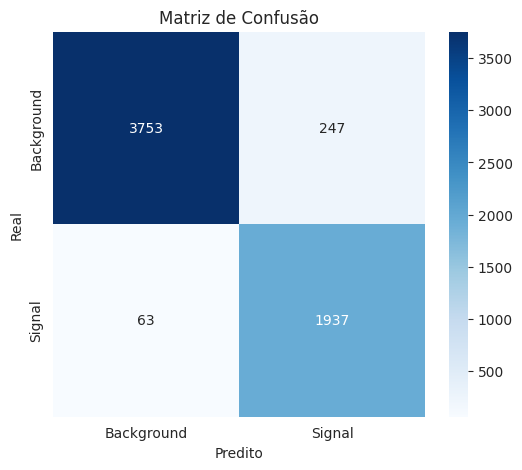

<Figure size 1200x800 with 0 Axes>

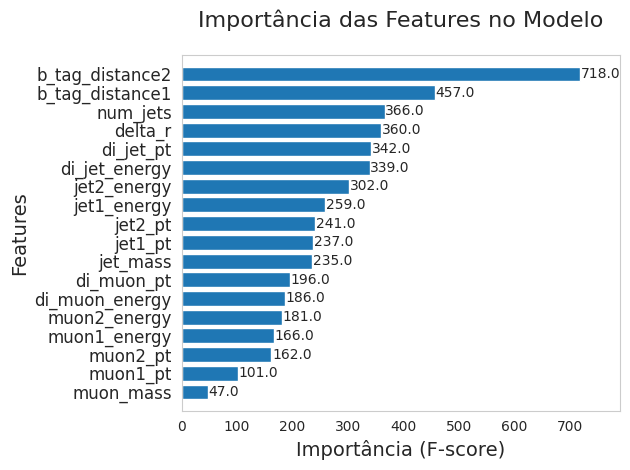

In [26]:
# Importações necessárias
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Definir os nomes das features (mantenha igual ao usado no treinamento)
feature_names = [
    'muon_mass', 'muon1_pt', 'muon2_pt', 'muon1_energy', 'muon2_energy',
    'di_muon_energy', 'di_muon_pt', 'jet_mass', 'jet1_pt', 'jet2_pt',
    'jet1_energy', 'jet2_energy', 'di_jet_energy', 'di_jet_pt', 'delta_r',
    'num_jets', 'b_tag_distance1', 'b_tag_distance2'
]

# 1. Classification Report
print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred))

# 2. Confusion Matrix
print("\n=== Confusion Matrix ===")
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

# Plot da Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, 
            annot=True, 
            fmt='d', 
            cmap='Blues',
            xticklabels=['Background', 'Signal'],
            yticklabels=['Background', 'Signal'])
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# 3. Importância das features com nomes personalizados
plt.figure(figsize=(12, 8))
ax = xgb.plot_importance(model, 
                        max_num_features=18, 
                        height=0.8,
                        importance_type='weight',
                        xlabel='F-score',
                        title='Importância das Features (XGBoost)',
                        grid=False)

# Ajustar os rótulos para usar os nomes corretos
ax.set_yticklabels(feature_names, fontsize=12)
ax.set_xlabel('Importância (F-score)', fontsize=14)
ax.set_ylabel('Features', fontsize=14)
ax.set_title('Importância das Features no Modelo', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

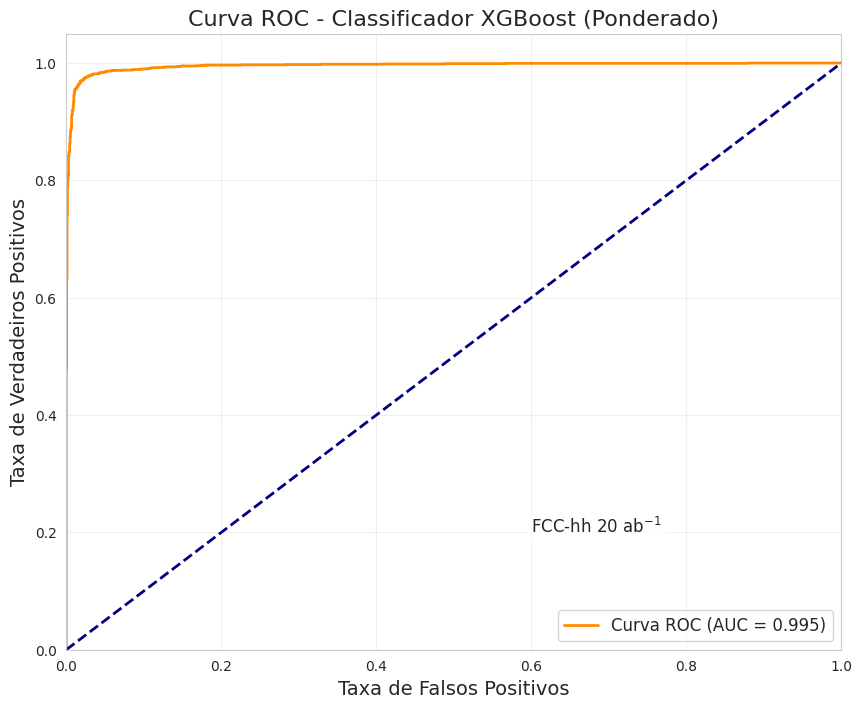

In [27]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calcular a curva ROC com pesos
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, sample_weight=weights_test)
roc_auc = auc(fpr, tpr)

# Plotar a curva ROC
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'Curva ROC (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos', fontsize=14)
plt.ylabel('Taxa de Verdadeiros Positivos', fontsize=14)
plt.title('Curva ROC - Classificador XGBoost (Ponderado)', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True, alpha=0.3)

# Adicionar informação sobre luminosidade
plt.text(0.6, 0.2, f'FCC-hh {TARGET_LUMINOSITY/1000:.0f} ab$^{{-1}}$',
         fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

plt.show()

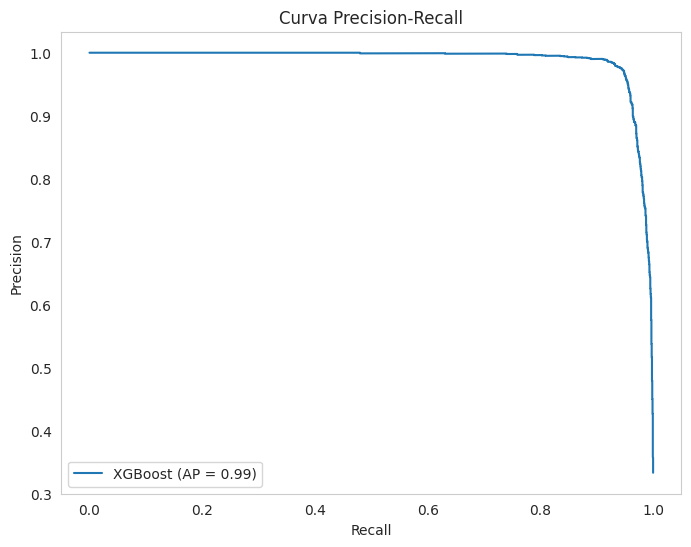


Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.98      0.94      0.96      4000
           1       0.89      0.97      0.93      2000

    accuracy                           0.95      6000
   macro avg       0.94      0.95      0.94      6000
weighted avg       0.95      0.95      0.95      6000


Average Precision (AP): 0.9884


In [28]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Calcular as métricas para a curva Precision-Recall
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
average_precision = average_precision_score(y_test, y_pred_proba)

# Plotar a curva Precision-Recall
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'XGBoost (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall')
plt.legend()
plt.grid()
plt.show()

# Você também pode adicionar outras métricas importantes
from sklearn.metrics import classification_report

print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))
print(f"\nAverage Precision (AP): {average_precision:.4f}")

In [29]:
import numpy as np
from scipy.stats import norm

def calculate_general_significance(y_true, y_weights, y_pred_weights):
    """
    Calcula a significância geral usando a separação das distribuições ponderadas
    
    Args:
        y_true: array com labels (0=background, 1=sinal)
        y_weights: array com pesos físicos dos eventos
        y_pred_weights: array com pesos preditos pelo modelo (probabilidades)
    
    Returns:
        Tuple: (significância, eficiência, pureza)
    """
    # Separar sinal e background
    sig_mask = y_true == 1
    bkg_mask = y_true == 0
    
    # Calcular médias e variâncias ponderadas
    mean_sig = np.average(y_pred_weights[sig_mask], weights=y_weights[sig_mask])
    mean_bkg = np.average(y_pred_weights[bkg_mask], weights=y_weights[bkg_mask])
    
    var_sig = np.average((y_pred_weights[sig_mask] - mean_sig)**2, weights=y_weights[sig_mask])
    var_bkg = np.average((y_pred_weights[bkg_mask] - mean_bkg)**2, weights=y_weights[bkg_mask])
    
    # Significância geral (distância entre as distribuições em unidades de sigma)
    significance = (mean_sig - mean_bkg) / np.sqrt(var_sig + var_bkg)
    
    # Métricas adicionais
    total_sig = np.sum(y_weights[sig_mask])
    total_bkg = np.sum(y_weights[bkg_mask])
    
    return significance, mean_sig, mean_bkg

# Calcular significância geral
general_sig, mean_signal, mean_bkg = calculate_general_significance(
    y_test,
    weights_test,
    y_pred_proba
)

# Resultados
print("\n=== Significância Geral da Análise ===")
print(f"Significância (σ): {general_sig:.4f}")
print(f"Média ponderada do sinal: {mean_signal:.6f}")
print(f"Média ponderada do background: {mean_bkg:.6f}")
print(f"Separação (Δμ/σ): {(mean_signal - mean_bkg)/np.sqrt(mean_signal**2 + mean_bkg**2):.4f}")

# Interpretação
print("\n=== Interpretação ===")
if general_sig > 5:
    print("✅ Excelente separação (significância > 5σ)")
elif general_sig > 3:
    print("⚠️ Separação moderada (3σ < significância ≤ 5σ)")
else:
    print("❌ Baixa separação (significância ≤ 3σ) - Necessita otimização")


=== Significância Geral da Análise ===
Significância (σ): 4.7495
Média ponderada do sinal: 0.934929
Média ponderada do background: 0.064247
Separação (Δμ/σ): 0.9291

=== Interpretação ===
⚠️ Separação moderada (3σ < significância ≤ 5σ)


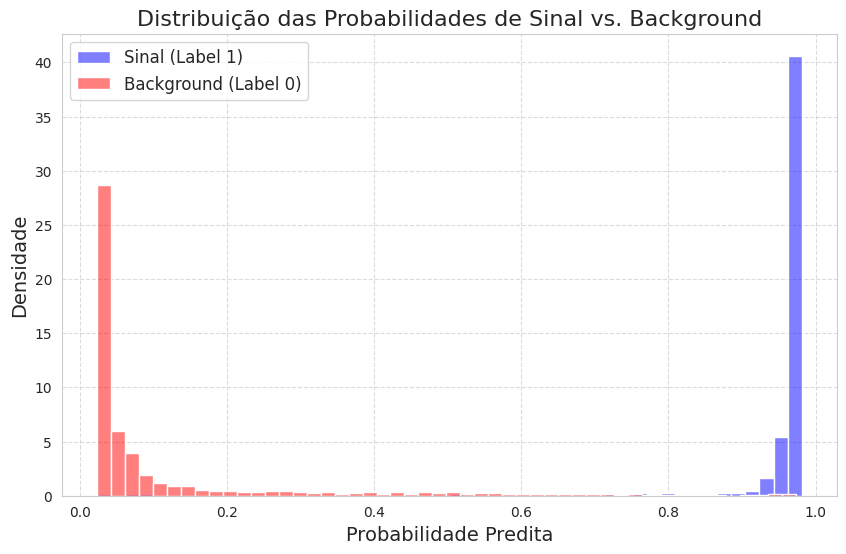

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

# Criar DataFrame com as probabilidades e labels verdadeiros
prob_df = pd.DataFrame({
    'Probability': y_pred_proba,
    'True Label': y_test
})

# Separar as probabilidades para sinal (label 1) e background (label 0)
signal_probs = prob_df[prob_df['True Label'] == 1]['Probability']
bkg_probs = prob_df[prob_df['True Label'] == 0]['Probability']

# Plotar as distribuições
plt.figure(figsize=(10, 6))
sns.histplot(signal_probs, bins=50, color='blue', alpha=0.5, label='Sinal (Label 1)', stat='density')
sns.histplot(bkg_probs, bins=50, color='red', alpha=0.5, label='Background (Label 0)', stat='density')

plt.xlabel('Probabilidade Predita', fontsize=14)
plt.ylabel('Densidade', fontsize=14)
plt.title('Distribuição das Probabilidades de Sinal vs. Background', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [31]:
def get_invariant_mass(df):
    """Filtra eventos com pelo menos 2 jats e retorna a massa invariante."""
    # Selecionar eventos onde os dois jatos têm pT > 0 (já processados)
    df_filtered = df[(df['jet1_pt'] > 0) & (df['jet2_pt'] > 0)].copy()
    return df_filtered[['jet_mass', 'label', 'weight']]  # Pega as colunas relevantes

# Aplicar aos DataFrames
signal_mass = get_invariant_mass(signal_df)
background_mass = get_invariant_mass(pd.concat([background1_df, background2_df]))

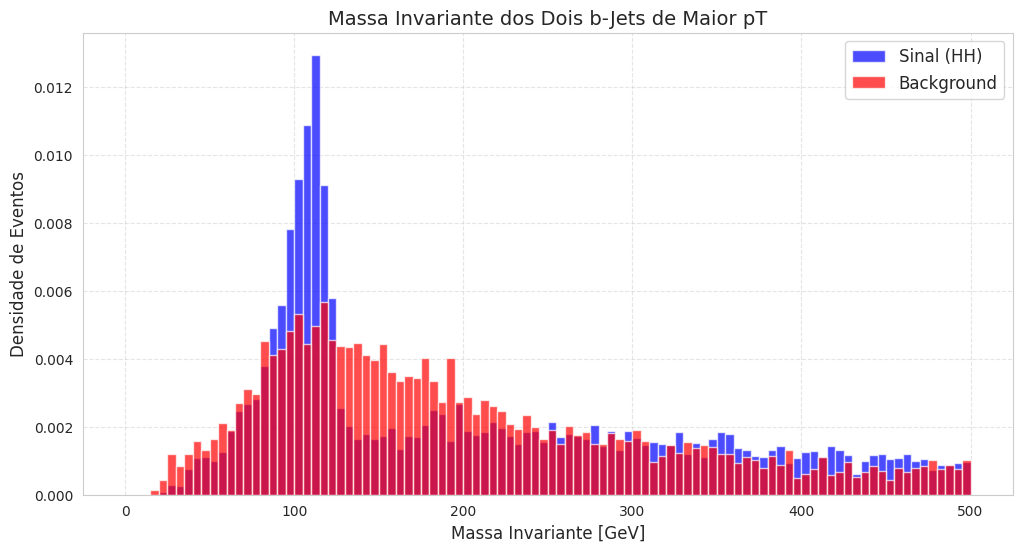

In [32]:
plt.figure(figsize=(12, 6))
plt.hist(
    signal_mass['jet_mass'],
    bins=100,
    range=(0, 500),
    color='blue',
    alpha=0.7,
    density=True,
    label='Sinal (HH)',
    weights=signal_mass['weight']
)
plt.hist(
    background_mass['jet_mass'],
    bins=100,
    range=(0, 500),
    color='red',
    alpha=0.7,
    density=True,
    label='Background',
    weights=background_mass['weight']
)
plt.xlabel('Massa Invariante [GeV]', fontsize=12)
plt.ylabel('Densidade de Eventos', fontsize=12)
plt.title('Massa Invariante dos Dois b-Jets de Maior pT', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [33]:
# Adicionar previsões do XGBoost aos DataFrames
signal_df['xgb_score'] = model.predict_proba(scaler.transform(signal_df[feature_names]))[:, 1]
background_df = pd.concat([background1_df, background2_df])
background_df['xgb_score'] = model.predict_proba(scaler.transform(background_df[feature_names]))[:, 1]

# Selecionar eventos classificados como sinal (probabilidade > 0.5)
signal_selected = signal_df[signal_df['xgb_score'] > 0.5]
bkg_selected = background_df[background_df['xgb_score'] > 0.5]  # (Opcional, para comparação)

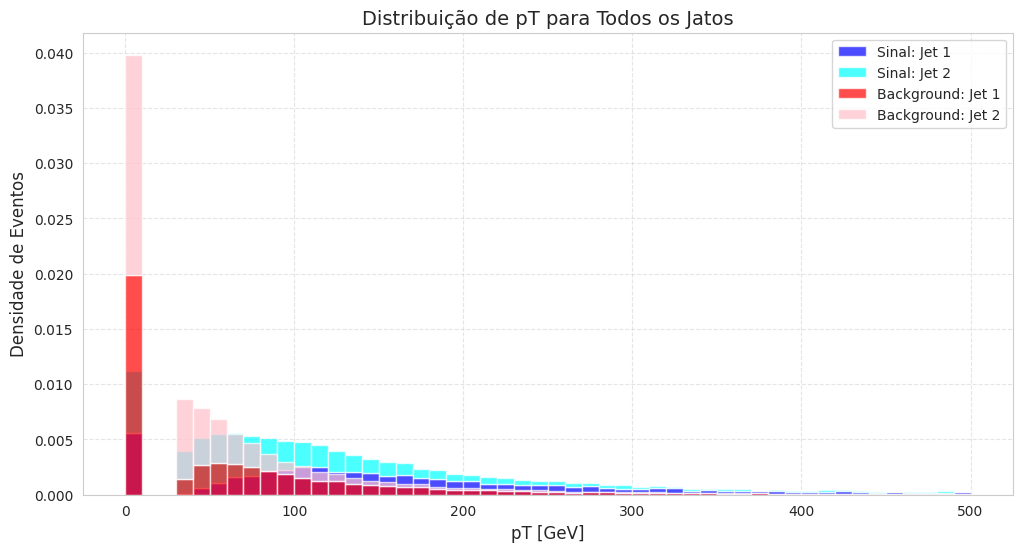

In [34]:
plt.figure(figsize=(12, 6))

# Sinal (HH) - Todos os jatos (jet1_pt e jet2_pt)
plt.hist(
    [signal_df['jet1_pt'], signal_df['jet2_pt']],
    bins=50,
    range=(0, 500),
    color=['blue', 'cyan'],
    alpha=0.7,
    label=['Sinal: Jet 1', 'Sinal: Jet 2'],
    density=True,
    stacked=True
)

# Background - Todos os jatos
plt.hist(
    [background_df['jet1_pt'], background_df['jet2_pt']],
    bins=50,
    range=(0, 500),
    color=['red', 'pink'],
    alpha=0.7,
    label=['Background: Jet 1', 'Background: Jet 2'],
    density=True,
    stacked=True
)

plt.xlabel('pT [GeV]', fontsize=12)
plt.ylabel('Densidade de Eventos', fontsize=12)
plt.title('Distribuição de pT para Todos os Jatos', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

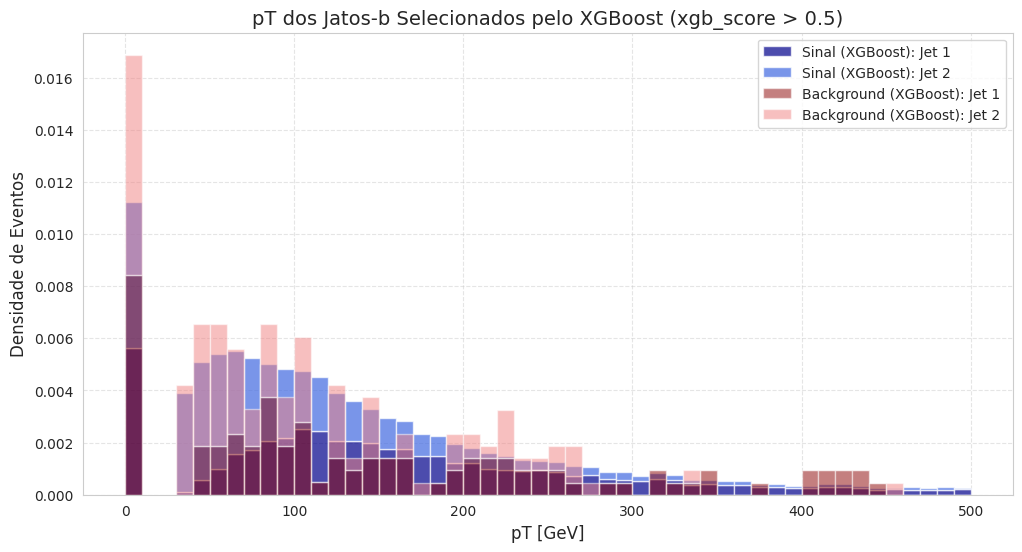

In [35]:
plt.figure(figsize=(12, 6))

# Sinal: Jatos-b selecionados (alto xgb_score)
plt.hist(
    [signal_selected['jet1_pt'], signal_selected['jet2_pt']],
    bins=50,
    range=(0, 500),
    color=['darkblue', 'royalblue'],
    alpha=0.7,
    label=['Sinal (XGBoost): Jet 1', 'Sinal (XGBoost): Jet 2'],
    density=True,
    stacked=True,
    weights=[signal_selected['weight'], signal_selected['weight']]  # Preserva pesos
)

# Background (opcional): Jatos classificados erroneamente como sinal
plt.hist(
    [bkg_selected['jet1_pt'], bkg_selected['jet2_pt']],
    bins=50,
    range=(0, 500),
    color=['darkred', 'lightcoral'],
    alpha=0.5,
    label=['Background (XGBoost): Jet 1', 'Background (XGBoost): Jet 2'],
    density=True,
    stacked=True,
    weights=[bkg_selected['weight'], bkg_selected['weight']]
)

plt.xlabel('pT [GeV]', fontsize=12)
plt.ylabel('Densidade de Eventos', fontsize=12)
plt.title('pT dos Jatos-b Selecionados pelo XGBoost (xgb_score > 0.5)', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

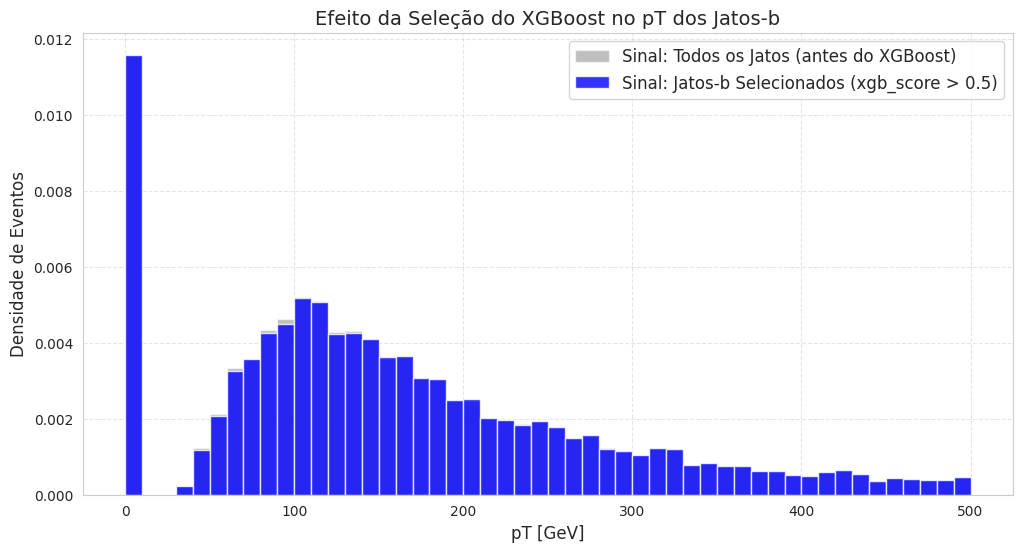

In [36]:
plt.figure(figsize=(12, 6))

# Todos os jatos-b do sinal (antes da seleção)
plt.hist(
    signal_df['jet1_pt'],
    bins=50,
    range=(0, 500),
    color='gray',
    alpha=0.5,
    label='Sinal: Todos os Jatos (antes do XGBoost)',
    density=True,
    weights=signal_df['weight']
)

# Jatos-b selecionados pelo XGBoost
plt.hist(
    signal_selected['jet1_pt'],
    bins=50,
    range=(0, 500),
    color='blue',
    alpha=0.8,
    label='Sinal: Jatos-b Selecionados (xgb_score > 0.5)',
    density=True,
    weights=signal_selected['weight']
)

plt.xlabel('pT [GeV]', fontsize=12)
plt.ylabel('Densidade de Eventos', fontsize=12)
plt.title('Efeito da Seleção do XGBoost no pT dos Jatos-b', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

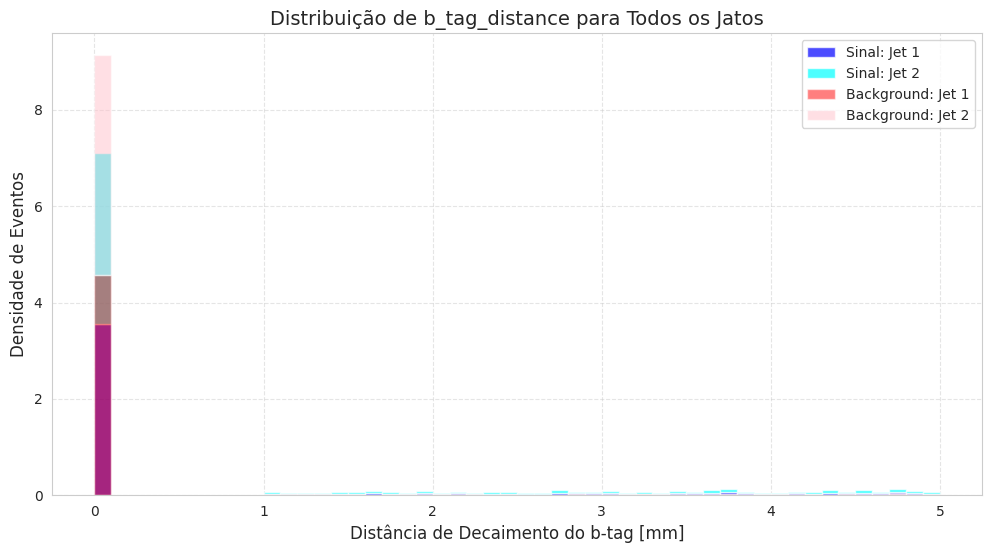

In [37]:
plt.figure(figsize=(12, 6))

# Sinal (HH) - Distâncias de b-tag
plt.hist(
    [signal_df['b_tag_distance1'], signal_df['b_tag_distance2']],
    bins=50,
    range=(0, 5),  # Ajuste o range conforme seus dados
    color=['blue', 'cyan'],
    alpha=0.7,
    label=['Sinal: Jet 1', 'Sinal: Jet 2'],
    density=True,
    stacked=True,
    weights=[signal_df['weight'], signal_df['weight']]
)

# Background - Distâncias de b-tag
plt.hist(
    [background_df['b_tag_distance1'], background_df['b_tag_distance2']],
    bins=50,
    range=(0, 5),
    color=['red', 'pink'],
    alpha=0.5,
    label=['Background: Jet 1', 'Background: Jet 2'],
    density=True,
    stacked=True,
    weights=[background_df['weight'], background_df['weight']]
)

plt.xlabel('Distância de Decaimento do b-tag [mm]', fontsize=12)
plt.ylabel('Densidade de Eventos', fontsize=12)
plt.title('Distribuição de b_tag_distance para Todos os Jatos', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

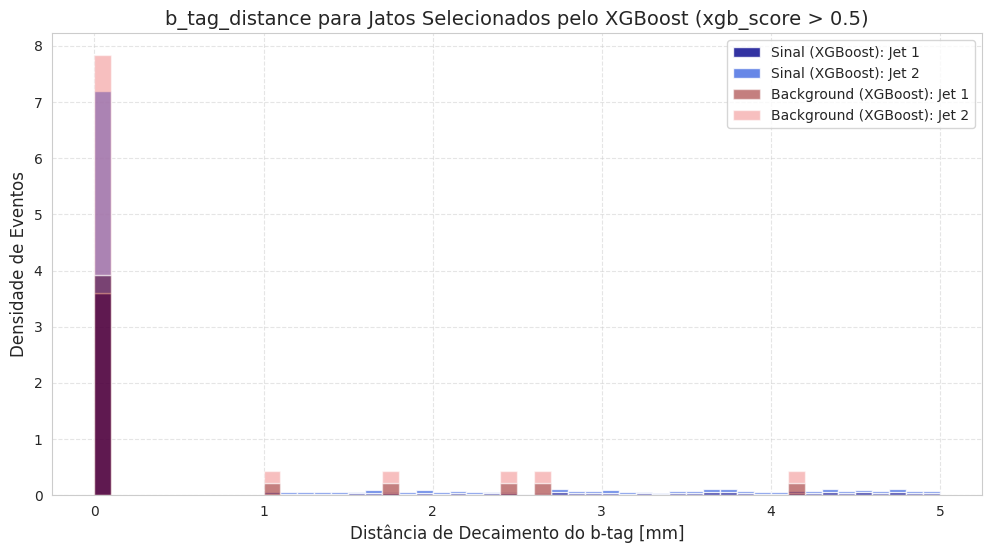

In [38]:
plt.figure(figsize=(12, 6))

# Sinal: Jatos-b selecionados (xgb_score > 0.5)
plt.hist(
    [signal_selected['b_tag_distance1'], signal_selected['b_tag_distance2']],
    bins=50,
    range=(0, 5),
    color=['darkblue', 'royalblue'],
    alpha=0.8,
    label=['Sinal (XGBoost): Jet 1', 'Sinal (XGBoost): Jet 2'],
    density=True,
    stacked=True,
    weights=[signal_selected['weight'], signal_selected['weight']]
)

# Background (opcional): Jatos erroneamente selecionados
plt.hist(
    [bkg_selected['b_tag_distance1'], bkg_selected['b_tag_distance2']],
    bins=50,
    range=(0, 5),
    color=['darkred', 'lightcoral'],
    alpha=0.5,
    label=['Background (XGBoost): Jet 1', 'Background (XGBoost): Jet 2'],
    density=True,
    stacked=True,
    weights=[bkg_selected['weight'], bkg_selected['weight']]
)

plt.xlabel('Distância de Decaimento do b-tag [mm]', fontsize=12)
plt.ylabel('Densidade de Eventos', fontsize=12)
plt.title('b_tag_distance para Jatos Selecionados pelo XGBoost (xgb_score > 0.5)', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

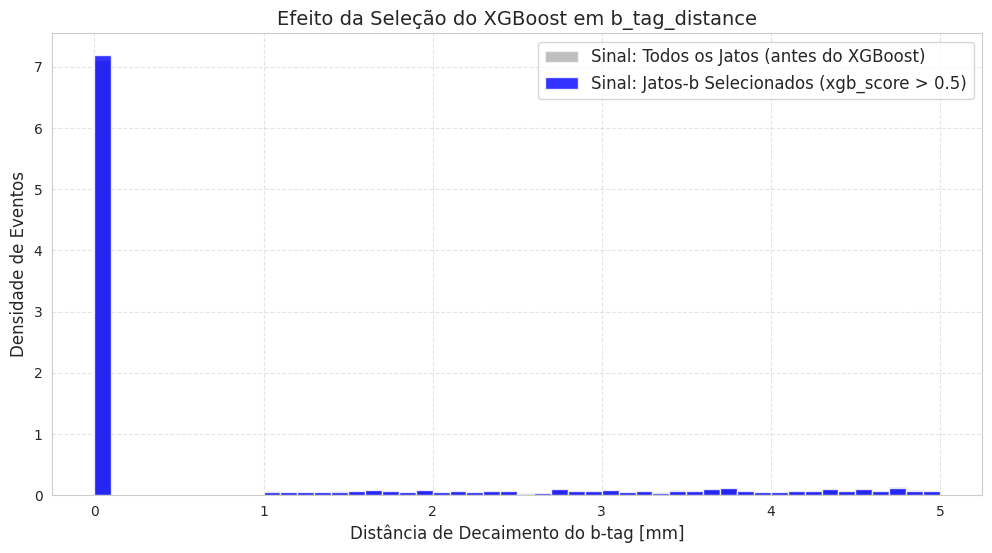

In [39]:
plt.figure(figsize=(12, 6))

# Todos os jatos-b do sinal (antes da seleção)
plt.hist(
    signal_df['b_tag_distance1'],
    bins=50,
    range=(0, 5),
    color='gray',
    alpha=0.5,
    label='Sinal: Todos os Jatos (antes do XGBoost)',
    density=True,
    weights=signal_df['weight']
)

# Jatos-b selecionados pelo XGBoost
plt.hist(
    signal_selected['b_tag_distance1'],
    bins=50,
    range=(0, 5),
    color='blue',
    alpha=0.8,
    label='Sinal: Jatos-b Selecionados (xgb_score > 0.5)',
    density=True,
    weights=signal_selected['weight']
)

plt.xlabel('Distância de Decaimento do b-tag [mm]', fontsize=12)
plt.ylabel('Densidade de Eventos', fontsize=12)
plt.title('Efeito da Seleção do XGBoost em b_tag_distance', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

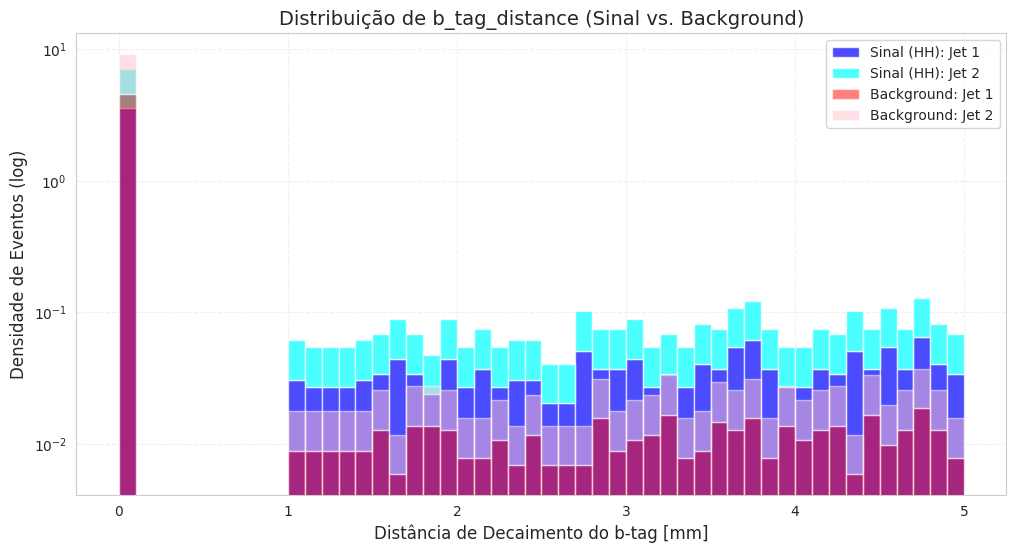

In [40]:
plt.figure(figsize=(12, 6))

# Configurações
bins = 50
range_b_tag = (0, 5)  # Ajuste conforme seus dados

# Sinal (HH)
plt.hist(
    [signal_df['b_tag_distance1'], signal_df['b_tag_distance2']],
    bins=bins,
    range=range_b_tag,
    color=['blue', 'cyan'],
    alpha=0.7,
    label=['Sinal (HH): Jet 1', 'Sinal (HH): Jet 2'],
    density=True,
    stacked=True,
    weights=[signal_df['weight'], signal_df['weight']]
)

# Background
plt.hist(
    [background_df['b_tag_distance1'], background_df['b_tag_distance2']],
    bins=bins,
    range=range_b_tag,
    color=['red', 'pink'],
    alpha=0.5,
    label=['Background: Jet 1', 'Background: Jet 2'],
    density=True,
    stacked=True,
    weights=[background_df['weight'], background_df['weight']]
)

# Formatação
plt.yscale('log')  # Escala logarítmica no eixo Y
plt.xlabel('Distância de Decaimento do b-tag [mm]', fontsize=12)
plt.ylabel('Densidade de Eventos (log)', fontsize=12)
plt.title('Distribuição de b_tag_distance (Sinal vs. Background)', fontsize=14)
plt.legend(fontsize=10, loc='upper right')
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

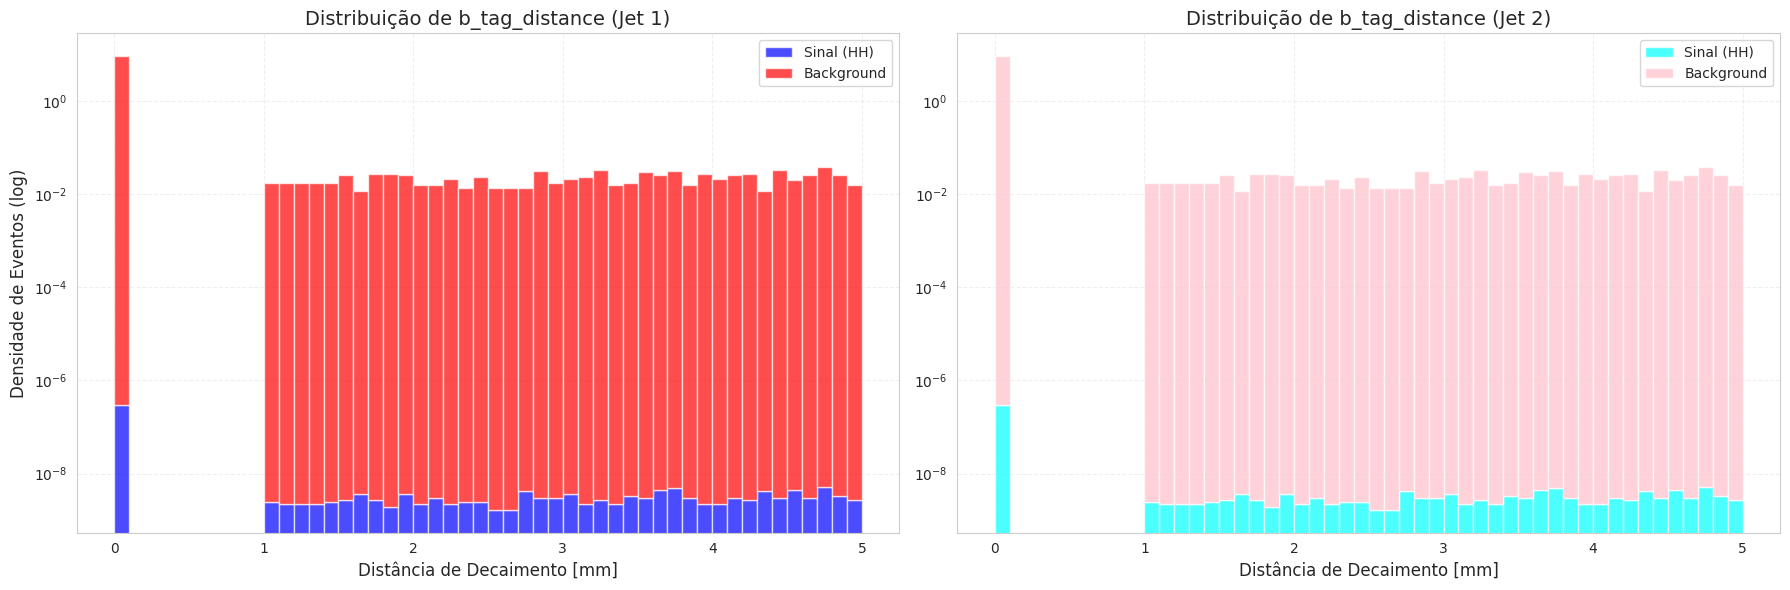

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Jet 1
axes[0].hist(
    [signal_df['b_tag_distance1'], background_df['b_tag_distance1']],
    bins=bins,
    range=range_b_tag,
    color=['blue', 'red'],
    alpha=0.7,
    label=['Sinal (HH)', 'Background'],
    density=True,
    stacked=True,
    weights=[signal_df['weight'], background_df['weight']]
)
axes[0].set_title('Distribuição de b_tag_distance (Jet 1)', fontsize=14)
axes[0].set_xlabel('Distância de Decaimento [mm]', fontsize=12)
axes[0].set_ylabel('Densidade de Eventos (log)', fontsize=12)
axes[0].set_yscale('log')
axes[0].legend(fontsize=10)
axes[0].grid(True, linestyle='--', alpha=0.3)

# Jet 2
axes[1].hist(
    [signal_df['b_tag_distance2'], background_df['b_tag_distance2']],
    bins=bins,
    range=range_b_tag,
    color=['cyan', 'pink'],
    alpha=0.7,
    label=['Sinal (HH)', 'Background'],
    density=True,
    stacked=True,
    weights=[signal_df['weight'], background_df['weight']]
)
axes[1].set_title('Distribuição de b_tag_distance (Jet 2)', fontsize=14)
axes[1].set_xlabel('Distância de Decaimento [mm]', fontsize=12)
axes[1].set_yscale('log')
axes[1].legend(fontsize=10)
axes[1].grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

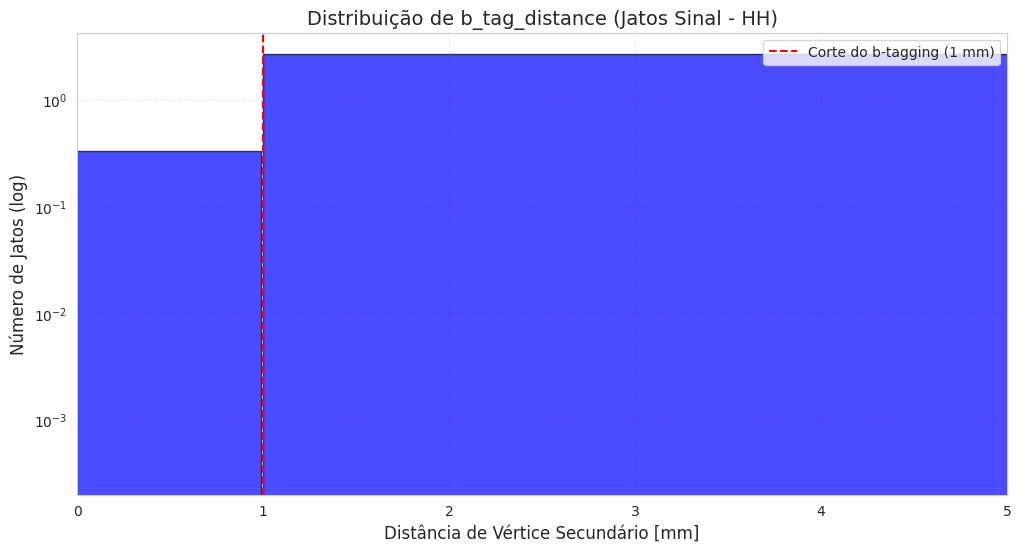

In [42]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 6))

# Dados
b_tag_distances = signal_df['b_tag_distance1']  # Pode ser jet1 ou jet2

# Configuração dos bins
bins = [0, 0.99] + list(np.linspace(1, b_tag_distances.max(), 20))  # Bin especial para 0 + bins normais para ≥1

# Plot
plt.hist(
    b_tag_distances,
    bins=bins,
    color='blue',
    alpha=0.7,
    edgecolor='black',
    weights=signal_df['weight']
)

# Destacar a região de corte
plt.axvline(x=1.0, color='red', linestyle='--', label='Corte do b-tagging (1 mm)')

# Formatação
plt.xlim(0, 5)  # Ajuste conforme necessário
plt.yscale('log')
plt.xlabel('Distância de Vértice Secundário [mm]', fontsize=12)
plt.ylabel('Número de Jatos (log)', fontsize=12)
plt.title('Distribuição de b_tag_distance (Jatos Sinal - HH)', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()